# Nonatomic routing games: System optima and equilibria via potential function formulation

Max Kapur | [https://www.maxkapur.com](maxkapur.com)

- Roughgarden, Tim. &ldquo;Routing Games.&rdquo; Chap. 18 in *Algorithmic Game Theory,* edited by Noam Nisan, Tim Roughgarden, Eva Tardos, and Vijay V. Vazirani. Cambridge University Press, 2007.

This demonstration considers *nonatomic routing games,* a class of optimization problem that has been studied since the 1920s and has gained importance in recent decades because of its applications in modern city infrastructure and communications network design.

A nonatomic routing game consists of a directed graph $G$, cost functions $c_e$ associated with each edge of the graph that give the unit cost of flow along that edge, and a vector of demands $r$ associated with various entering and exit nodes.

An intuitive example of $G$ is a subway network. In the code, $G$ is represented by a list of tuples `edges = [(5, 1), (5, 2), (1, 2), ... ]`, which specify pairs of stations that are linked by a subway. If a subway can travel in both directions between stations A and B, then we need to include both the edges `(A, B)` and `(B, A)`, because the graph is directed.

There are various kinds of trips people could want to make. In the code below, we consider trip 1, which goes from station 1 to 3, and trip 2, which goes from station 5 to 6. The vector $r$ contains two entries, which indicates how many people want to make each trip. The problem is *nonatomic* because instead of modeling individual behavior, we consider an overall flow of people, and $r_i$ is a fraction of the total. In the code below, the trips are encoded as `stpairs = [(1, 3), (5, 6)]`, and the vector $r$ as `traffic = [.3, .7]`. 

Finally, the cost function $c_e$ indicates how much people dislike riding a particular link in the subway network. The problem is interesting because people are averse to crowding, so $c_e$ is usually an increasing function of the number of people who are riding that link. In the code below, the marginal cost along each edge a linear function of the form $c_e = a_e + b_e x$, where $x$ is the flow along the edge. This means that the total cost is a quadratic function. The coefficients $a_e$ and $b_e$ are stored in the array `ab` below. 

There are two kinds of flow we are interested in. The first is the socially *optimal* flow, which is the flow that minimizes the total cost that everyone experiences on every leg of their journey.

Unfortunately, under the socially optimal flow, there are certain individuals for whom they can take a different route and decrease their subjective cost (while increasing that of others). So, we also want to compute an *equilibrium* flow, which is the more likely flow to arise in real life, because nobody has an incentive to change up their route.

The ratio between the cost of the equilibrium flow and the optimal flow is called the *price of anarchy,* which is the price of letting people choose their own route instead of forcing them to take the route the optimizer tells them to.

In [1]:
using Plots
using JuMP
using Ipopt
using Polynomials

include("NonatomicRouting.jl")

pathcosts

Let's build a small network with six nodes in it. 

In [2]:
# Edges available in the network
edges = [(5, 1),
         (5, 2),
         (1, 2),
         (1, 3),
         (2, 3),
         (2, 4),
         (3, 6),
         (4, 6)]

# Coords of each node, for plotting
coords = [1 1; 1 0; 2 1; 2 0; 0 0.5; 3 0.5]

# Marginal cost on edge one is 0.427 + 0.736 x, where x is the flow
# Social cost associated with this edge is then (0.427 + 0.736 x) x
ab = [ 0.427058   0.748348
       0.621136   0.750686
       0.693977   0.870948
       0.0202443  0.923078
       0.522386   0.975655
       0.764939   0.573718
       0.713569   0.313074
       0.0409294  0.541023 ]

costs = Array{Polynomial{Float64}}([Polynomial([a, b]) for (a, b) in eachrow(ab)])

# Source-sink demand pairs and volume of demand for each
stpairs = [(1, 3), (5, 6)]
traffic = [.3, .7]

# Constructor automatically computes possible paths for each commodity
# as well as total cost functions.
instance = RoutingGame(edges, costs, stpairs, traffic)

RoutingGame{Float64, Int64}([(5, 1), (5, 2), (1, 2), (1, 3), (2, 3), (2, 4), (3, 6), (4, 6)], Polynomial{Float64, _A} where _A[Polynomial(0.427058 + 0.748348*x), Polynomial(0.621136 + 0.750686*x), Polynomial(0.693977 + 0.870948*x), Polynomial(0.0202443 + 0.923078*x), Polynomial(0.522386 + 0.975655*x), Polynomial(0.764939 + 0.573718*x), Polynomial(0.713569 + 0.313074*x), Polynomial(0.0409294 + 0.541023*x)], Polynomial{Float64, _A} where _A[Polynomial(0.427058*x + 0.748348*x^2), Polynomial(0.621136*x + 0.750686*x^2), Polynomial(0.693977*x + 0.870948*x^2), Polynomial(0.0202443*x + 0.923078*x^2), Polynomial(0.522386*x + 0.975655*x^2), Polynomial(0.764939*x + 0.573718*x^2), Polynomial(0.713569*x + 0.313074*x^2), Polynomial(0.0409294*x + 0.541023*x^2)], [(1, 3), (5, 6)], [0.3, 0.7], [[[3, 5], [4]], [[1, 3, 5, 7], [1, 3, 6, 8], [1, 4, 7], [2, 5, 7], [2, 6, 8]]])

As the plot below shows, there are two kinds of customers in the network: Those who wish to travel from node `1` to `3`, and those who wish to travel from `5` to `6`.

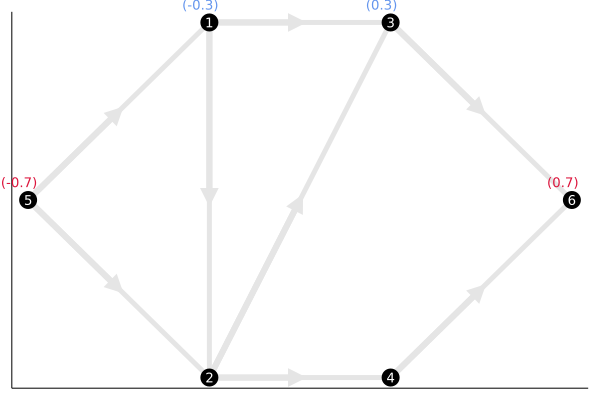

In [3]:
shownet(instance, coords)

Compute the system optimum and equilibrium flow for this instance. Both are constrained convex minimization problems. In both cases, the constraints are that the flow in each edge must be positive, and the amount of flow exiting each node must equal the amount coming in.

For the system optimum, we simply minimize the total cost along each edge, which is the marginal cost times the amount of flow along the edge.

For the equilibrium flow, it suffices to minimize a potential function, defined as the sum of the antiderivatives of the marginal cost along each edge. It is possible to show that minimizing this function produces a flow in which for every path that has nonzero flow, there is no way for people currently traveling along that path to switch to one with lesser marginal cost.

In [4]:
sysoptflow, equilibrium = solveroutinggame(instance)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.13.4, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        7
Number of nonzeros in inequality constraint Jacobian.:       20
Number of nonzeros in Lagrangian Hessian.............:       18

Total number of variables............................:        7
                     variables with only lower bounds:        7
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equal

((pathflows =   [2, 4]  =  0.0716929
  [1, 2]  =  0.3
  [1, 1]  =  7.96375e-9
  [2, 5]  =  0.353087
  [2, 2]  =  7.02002e-9
  [2, 1]  =  7.85805e-9
  [2, 3]  =  0.27522, edgeflows = [0.2752202364305247, 0.4247797635694752, 2.2841817971593786e-8, 0.5752202135887067, 0.0716929615915753, 0.35308682481971787, 0.346913175180282, 0.35308682481971787]), (pathflows =   [2, 4]  =  4.60025e-8
  [1, 2]  =  0.3
  [1, 1]  =  0.0
  [2, 5]  =  0.363628
  [2, 2]  =  0.0
  [2, 1]  =  0.0
  [2, 3]  =  0.336372, edgeflows = [0.3363722320086737, 0.36362777030694643, 0.0, 0.636372233979517, 4.6002454485266734e-8, 0.3636277243044919, 0.33637227801112823, 0.3636277243044919]))

The price of anarchy for this instance was `1.0087`, which is quite close to one. In fact, it can be shown that for cost functions of this form, the price of anarchy never exceeds $4/3$.

Plotting the flow, we see that the results are very similar. However, in the first case, those in the red demand category traveling along the path that includes the edge `(2, 3)` will end up better off if they switch to the path below it.

MC means marginal cost and SC means social cost, the product of the marginal cost and the flow.

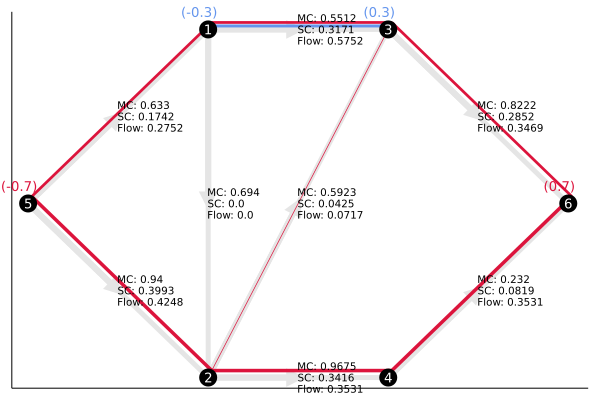

In [5]:
optres = shownet(instance, coords, sysoptflow)

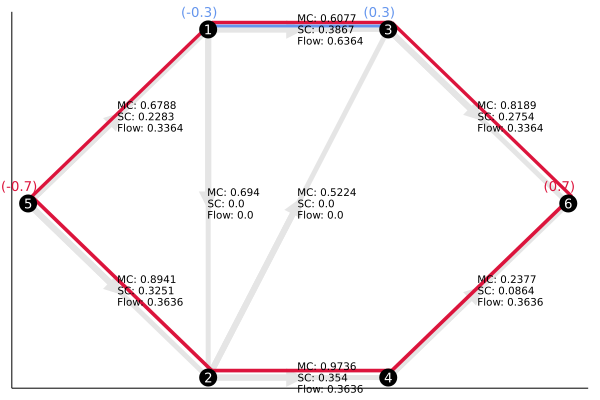

In [6]:
eqres = shownet(instance, coords, equilibrium)

Here is a convenience function that prints out the *total* marginal cost associated with each of the paths in each category. By inspection, we can verify that this is the equilibrium. Within each category, all the paths that have nonzero flow have equal marginal cost, and all the other paths have higher marginal cost.

In [7]:
pathcosts(instance, equilibrium)

c = 1
  Path: [(1, 2), (2, 3)]
    Flow      : 0
    Marg. cost: 1.2163630448825247
  Path: [(1, 3)]
    Flow      : 0.30000000197084337
    Marg. cost: 0.6076655089973446
c = 2
  Path: [(5, 1), (1, 2), (2, 3), (3, 6)]
    Flow      : 0
    Marg. cost: 2.7140229465278076
  Path: [(5, 1), (1, 2), (2, 4), (4, 6)]
    Flow      : 0
    Marg. cost: 2.583977620098141
  Path: [(5, 1), (1, 3), (3, 6)]
    Flow      : 0.3363722320086737
    Marg. cost: 2.1053254106426276
  Path: [(5, 2), (2, 3), (3, 6)]
    Flow      : 0
    Marg. cost: 2.235370735829221
  Path: [(5, 2), (2, 4), (4, 6)]
    Flow      : 0.3636277243044919
    Marg. cost: 2.1053254093995544


2-element Vector{Any}:
 Any[1.2163630448825247, 0.6076655089973446]
 Any[2.7140229465278076, 2.583977620098141, 2.1053254106426276, 2.235370735829221, 2.1053254093995544]

In [8]:
savefig(optres, "plots/optimum.png")
savefig(eqres, "plots/equilibrium.png")